# Multi-factor Model

## Packages
When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages will be imported for you. We recommend you don't add any import statements, otherwise the grader might not be able to run your code.

The other packages that we're importing are `project_helper` and `project_tests`. These are custom packages built to help you solve the problems.  The `project_helper` module contains utility functions and graph functions. The `project_tests` contains the unit tests for all the problems.

### Install Packages
You can view the list of packages to install, as mentioned in `requirements.txt` as:

`! cat requirements.txt` 

In [ ]:
import sys
!{sys.executable} -m pip install -r requirements.txt

In [2]:
!cat requirements.txt

alphalens==0.3.2
colour==0.1.5
cvxpy==1.0.3
cycler==0.10.0
numpy==1.13.3
pandas==0.18.1
plotly==2.2.3
pyparsing==2.2.0
python-dateutil==2.6.1
pytz==2017.3
requests==2.18.4
scipy==1.0.0
scikit-learn==0.19.1
six==1.11.0
tables==3.3.0
tqdm==4.19.5
zipline===1.2.0


### Update Packages 
Python packages get updated with time. If a compilation issue arises in the below cells, we recommend you to **upgrade** the specific package as:

`!{sys.executable} -m pip install <package-name> --upgrade`

A sample upgrade is done in next cell for `tensorflow` and `numpy` packages. 

In [ ]:
!{sys.executable} -m pip install tensorflow --upgrade 
!{sys.executable} -m pip install numpy --upgrade

### Load Packages

In [50]:
import cvxpy as cvx
import numpy as np
import pandas as pd
import time
import project_tests
import project_helper

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)


## Data Bundle
We'll be using Zipline to handle our data. We've created a end of day data bundle for this project. Run the cell below to register this data bundle in zipline.

In [51]:
import os
import project_helper
from zipline.data import bundles

os.environ['ZIPLINE_ROOT'] = os.getcwd() + '/project_4_eod'

ingest_func = bundles.csvdir.csvdir_equities(['daily'], project_helper.EOD_BUNDLE_NAME)
bundles.register(project_helper.EOD_BUNDLE_NAME, ingest_func)

print('Data Registered')

Data Registered


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Overwriting bundle with name 'eod-quotemedia'
  


## Build Pipeline Engine
We'll be using Zipline's pipeline package to access our data for this project. To use it, we must build a pipeline engine. Run the cell below to build the engine.

In [52]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar


universe = AverageDollarVolume(window_length=120).top(500) 
trading_calendar = get_calendar('NYSE') 
bundle_data = bundles.load(project_helper.EOD_BUNDLE_NAME)
engine = project_helper.build_pipeline_engine(bundle_data, trading_calendar)

### View Data
With the pipeline engine built, let's get the stocks at the end of the period in the universe we're using. We'll use these tickers to generate the returns data for the our risk model.

In [53]:
universe_end_date = pd.Timestamp('2016-01-05', tz='UTC')

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers

[Equity(0 [A]),
 Equity(1 [AAL]),
 Equity(2 [AAP]),
 Equity(3 [AAPL]),
 Equity(4 [ABBV]),
 Equity(5 [ABC]),
 Equity(6 [ABT]),
 Equity(7 [ACN]),
 Equity(8 [ADBE]),
 Equity(9 [ADI]),
 Equity(10 [ADM]),
 Equity(11 [ADP]),
 Equity(12 [ADS]),
 Equity(13 [ADSK]),
 Equity(14 [AEE]),
 Equity(15 [AEP]),
 Equity(16 [AES]),
 Equity(17 [AET]),
 Equity(18 [AFL]),
 Equity(19 [AGN]),
 Equity(20 [AIG]),
 Equity(21 [AIV]),
 Equity(22 [AIZ]),
 Equity(23 [AJG]),
 Equity(24 [AKAM]),
 Equity(25 [ALB]),
 Equity(26 [ALGN]),
 Equity(27 [ALK]),
 Equity(28 [ALL]),
 Equity(29 [ALLE]),
 Equity(30 [ALXN]),
 Equity(31 [AMAT]),
 Equity(32 [AMD]),
 Equity(33 [AME]),
 Equity(34 [AMG]),
 Equity(35 [AMGN]),
 Equity(36 [AMP]),
 Equity(37 [AMT]),
 Equity(38 [AMZN]),
 Equity(39 [ANDV]),
 Equity(40 [ANSS]),
 Equity(41 [ANTM]),
 Equity(42 [AON]),
 Equity(43 [AOS]),
 Equity(44 [APA]),
 Equity(45 [APC]),
 Equity(46 [APD]),
 Equity(47 [APH]),
 Equity(48 [ARE]),
 Equity(49 [ARNC]),
 Equity(50 [ATVI]),
 Equity(51 [AVB]),
 Equity(

## Get Returns
Not that we have our pipeline built, let's access the returns data. We'll start by building a data portal.

In [54]:
from zipline.data.data_portal import DataPortal


data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

To make the code easier to read, we've built the helper function `get_pricing` to get the pricing from the data portal. 

In [55]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

### View Data
Let's get returns data for our risk model using the `get_pricing` function. For this model, we'll be looking back to 5 years of data.

In [56]:
five_year_returns = \
    get_pricing(
        data_portal,
        trading_calendar,
        universe_tickers,
        universe_end_date - pd.DateOffset(years=5),
        universe_end_date)\
    .pct_change()[1:].fillna(0)

five_year_returns

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: offset is deprecated. Use freq instead
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: offset is deprecated. Use freq instead
  This is separate from the ipykernel package so we can avoid doing imports until


,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
2011-01-07 00:00:00+00:00,0.00843652,0.01423027,0.02670202,0.00714639,0.00000000,0.00199434,0.00416541,0.00164769,-0.00712736,-0.00581846,...,-0.00183775,-0.00561865,0.00546091,-0.00404361,-0.01395259,0.00000000,0.01245693,-0.00018145,-0.01045802,0.00000000
2011-01-10 00:00:00+00:00,-0.00417428,0.00619534,0.00743543,0.01885158,0.00000000,-0.00571429,-0.00889600,-0.00885384,0.02871411,0.00292626,...,0.00094687,0.00781438,-0.00608100,0.01046585,0.00973303,0.00000000,0.00143979,0.00778351,-0.01794496,0.00000000
2011-01-11 00:00:00+00:00,-0.00188630,-0.04364361,-0.00592730,-0.00236744,0.00000000,0.00978303,-0.00206747,0.01371668,0.00060680,0.00875316,...,0.00131385,0.01017933,0.00744242,0.00735141,0.00611644,0.00000000,-0.00646974,0.03567570,0.00746728,0.00000000
2011-01-12 00:00:00+00:00,0.01725375,-0.00823708,0.01338721,0.00813289,0.00000000,-0.00597922,-0.00101061,0.02296913,0.01795027,0.00025710,...,0.00498609,0.01566621,0.01176334,0.02718194,0.00438630,0.00000000,0.00263106,0.01474083,-0.01190269,0.00000000
2011-01-13 00:00:00+00:00,-0.00455851,0.00095465,0.00303109,0.00365656,0.00000000,0.01492537,-0.00445119,-0.00040011,-0.00571905,-0.00501221,...,0.03049927,-0.00321668,0.00169383,0.00054651,-0.01823475,0.00000000,-0.00508430,-0.00466453,-0.00917796,0.00000000
2011-01-14 00:00:00+00:00,0.00343886,-0.00915594,0.00302193,0.00810620,0.00000000,0.00139452,-0.01011076,0.00259000,0.01228280,0.01982692,...,0.02660653,0.02589425,0.01474258,-0.00028748,0.02649446,0.00000000,-0.02166101,0.00594885,0.03317747,0.00000000
2011-01-18 00:00:00+00:00,0.03425353,-0.06208490,-0.00428562,-0.02247419,0.00000000,0.02088872,0.00662116,0.00699843,0.01154188,0.03264518,...,0.00167843,0.00250133,0.01116324,0.01158879,0.00604402,0.00000000,0.02945339,0.00699753,-0.00853448,0.00000000
2011-01-19 00:00:00+00:00,-0.01022379,-0.00892857,0.00875376,-0.00531448,0.00000000,-0.01714410,0.00275342,-0.00296182,-0.00789936,-0.02057462,...,-0.01483416,-0.02358990,-0.00596800,-0.01989880,-0.01284667,0.00000000,0.00081838,-0.00409759,-0.01843318,0.00000000
2011-01-20 00:00:00+00:00,-0.00849568,0.02195299,-0.00473189,-0.01818900,0.00000000,0.00479450,0.01332249,0.01871257,-0.01238573,-0.00281761,...,-0.02451226,0.00774353,-0.00626137,-0.00084112,-0.03379775,0.00000000,-0.01318157,-0.00161165,-0.00797236,0.00000000
2011-01-21 00:00:00+00:00,0.00787281,-0.04103759,0.00554409,-0.01791080,0.00000000,0.01064197,-0.00085307,-0.00195169,-0.00656913,-0.00411277,...,0.00000000,0.00061472,0.01582494,-0.00304798,-0.00087153,0.00000000,-0.00759032,0.00932467,0.02402000,0.00000000


# Statistical Risk Model
It's time to build the risk model. You'll be creating a statistical risk model using PCA. So, the first thing is building the PCA model.
## Fit PCA
Implement `fit_pca` to fit a PCA model to the returns data

In [57]:
from sklearn.decomposition import PCA


def fit_pca(returns, num_factor_exposures, svd_solver):
    """
    Fit PCA model with returns.

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    num_factor_exposures : int
        Number of factors for PCA
    svd_solver: str
        The solver to use for the PCA model

    Returns
    -------
    pca : PCA
        Model fit to returns
    """
    # Initialize the PCA
    pca = PCA(n_components = num_factor_exposures, svd_solver = svd_solver)
    
    # Fit PCA to the dataset
    pca.fit(returns)
    
    return pca


project_tests.test_fit_pca(fit_pca)

Tests Passed


### View Data
Let's see what the model looks like. First, we'll look at the PCA components.

In [58]:
num_factor_exposures = 20
pca = fit_pca(five_year_returns, num_factor_exposures, 'full')

pca.components_

array([[-0.04316847, -0.05874471, -0.03433256, ..., -0.03843904,
        -0.06092493, -0.01367163],
       [ 0.01955111,  0.19637679,  0.03451503, ...,  0.01749339,
        -0.01044197,  0.01892192],
       [-0.00993375,  0.07868756,  0.01133839, ..., -0.0157519 ,
         0.01261759,  0.01867875],
       ...,
       [-0.01174265,  0.01398085,  0.05143999, ...,  0.04125323,
         0.0035229 ,  0.03682367],
       [ 0.00526925, -0.04680674,  0.05716915, ...,  0.00671842,
        -0.02193923,  0.00833979],
       [-0.00535269, -0.01599057,  0.08414961, ..., -0.01540844,
         0.02188794,  0.01500221]])

Let's also look at the PCA's percent of variance explained by each factor

<Container object of 20 artists>

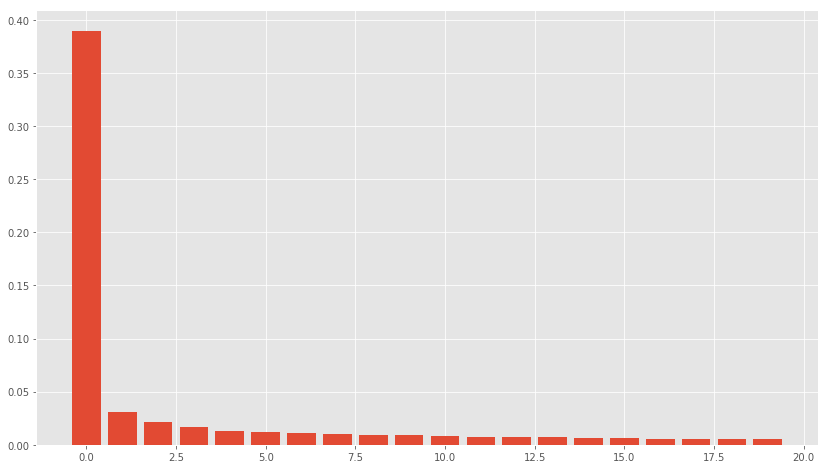

In [59]:
plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_)

You will see that the first factor dominates. The precise definition of each factor in a latent model is unknown, however we can guess at the likely interpretation.

## Factor Betas
Implement `factor_betas` to get the factor betas from the PCA model.

In [60]:
def factor_betas(pca, factor_beta_indices, factor_beta_columns):
    """
    Get the factor betas from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    factor_beta_indices : 1 dimensional Ndarray
        Factor beta indices
    factor_beta_columns : 1 dimensional Ndarray
        Factor beta columns

    Returns
    -------
    factor_betas : DataFrame
        Factor betas
    """
    # Testing
    assert len(factor_beta_indices.shape) == 1
    assert len(factor_beta_columns.shape) == 1
    
    # Factor betas
    factor_betas = pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)
    
    return factor_betas

project_tests.test_factor_betas(factor_betas)

Tests Passed


### View Data
Let's view the factor betas from this model.

In [61]:
risk_model = {}
risk_model['factor_betas'] = factor_betas(pca, five_year_returns.columns.values, np.arange(num_factor_exposures))

risk_model['factor_betas']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Equity(0 [A]),-0.04316847,0.01955111,-0.00993375,0.01054038,-0.01819821,0.01074517,0.00112915,0.03973914,-0.01380519,0.01273651,-0.02384028,-0.00141663,0.02099338,0.03460997,-0.03048936,0.03360635,-0.01142920,-0.01174265,0.00526925,-0.00535269
Equity(1 [AAL]),-0.05874471,0.19637679,0.07868756,0.08209582,0.34847826,-0.13808246,0.07129285,0.10524788,-0.04588957,-0.08547793,0.00328328,0.10534284,0.06721603,-0.04405955,-0.02231617,0.01726309,-0.03310836,0.01398085,-0.04680674,-0.01599057
Equity(2 [AAP]),-0.03433256,0.03451503,0.01133839,-0.02543666,-0.00817211,-0.01318319,-0.06095238,0.00654915,-0.03265404,-0.01351522,0.02896685,0.03836520,-0.04960451,-0.00524576,-0.02196994,0.02976718,-0.01163585,0.05143999,0.05716915,0.08414961
Equity(3 [AAPL]),-0.03409988,-0.00139319,0.03946700,-0.01721303,-0.03046983,-0.01757067,0.02325117,0.01142987,-0.02656849,-0.00771904,0.02686350,0.00731877,0.00481832,0.01288623,0.05256513,-0.07344470,-0.03179158,0.09079374,-0.01118851,0.04291373
Equity(4 [ABBV]),-0.01803099,0.02568151,0.00435183,-0.07078179,0.01319937,0.05427710,-0.01567842,0.04046172,-0.01245487,-0.03515086,-0.05132433,-0.04041614,-0.05120320,-0.01858166,-0.01126857,-0.04200714,0.01588559,0.04598554,0.01599288,0.06587978
Equity(5 [ABC]),-0.02890016,0.03259161,-0.00742074,-0.03355183,-0.01152149,0.02648421,0.01084965,-0.00570393,0.01354800,-0.02967931,-0.03161765,0.01715152,-0.00304998,0.02635564,0.00787900,0.00833106,-0.01834622,-0.01391370,0.01062042,-0.02739565
Equity(6 [ABT]),-0.02905740,0.02977821,-0.02970871,-0.03574263,-0.01157351,0.06020073,-0.02004042,0.04098522,-0.01803987,-0.00620785,-0.03157790,-0.02308041,-0.01436789,-0.00054254,-0.01932887,0.01428819,-0.03938064,0.01071208,0.01712006,0.00210689
Equity(7 [ACN]),-0.04337745,0.00256907,0.00413229,-0.00349265,-0.05430743,0.00537434,0.00277996,0.03043220,-0.01880168,-0.00178336,-0.03540357,-0.01093170,0.02611241,-0.01233115,0.00322097,0.01770011,-0.00285123,-0.01235874,-0.01400935,-0.03855653
Equity(8 [ADBE]),-0.04730285,0.02661175,0.03057072,-0.02114690,-0.04838794,-0.00708698,0.00743385,0.00747095,0.01487098,-0.00153422,-0.01238383,-0.00667442,0.03500718,-0.04336579,0.01060255,-0.00637875,0.02127339,-0.03638845,0.00126811,-0.04844555
Equity(9 [ADI]),-0.04712287,-0.00381150,0.05600847,-0.01553775,-0.06946243,-0.00560418,0.10070366,0.06307694,0.00160769,0.01912993,0.01101680,0.00348733,-0.05465749,-0.04223802,-0.00014275,-0.04843166,0.00374282,0.04583322,0.01483456,0.00768623


## Factor Returns
Implement `factor_returns` to get the factor returns from the PCA model using the returns data.

In [62]:
def factor_returns(pca, returns, factor_return_indices, factor_return_columns):
    """
    Get the factor returns from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    returns : DataFrame
        Returns for each ticker and date
    factor_return_indices : 1 dimensional Ndarray
        Factor return indices
    factor_return_columns : 1 dimensional Ndarray
        Factor return columns

    Returns
    -------
    factor_returns : DataFrame
        Factor returns
    """
    # Testing
    assert len(factor_return_indices.shape) == 1
    assert len(factor_return_columns.shape) == 1
    
    # Factor returns
    factor_returns = pd.DataFrame(pca.transform(returns), index = factor_return_indices, columns = factor_return_columns)
    
    return factor_returns

project_tests.test_factor_returns(factor_returns)

Tests Passed


### View Data
Let's see what these factor returns looks like over time.

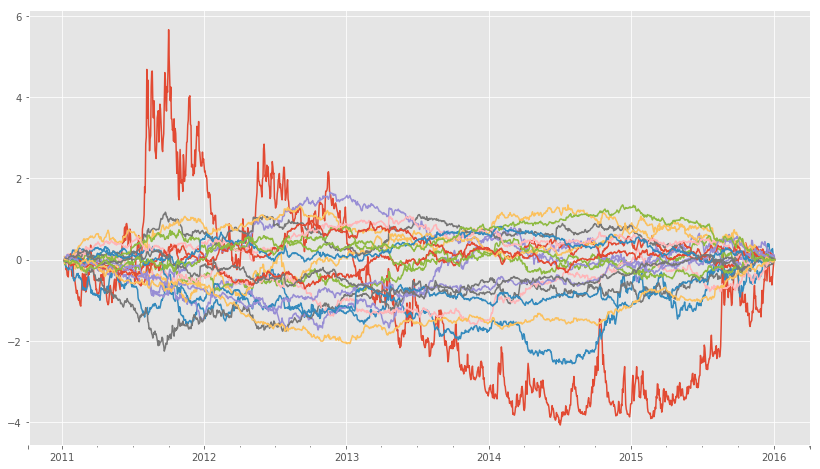

In [63]:
risk_model['factor_returns'] = factor_returns(
    pca,
    five_year_returns,
    five_year_returns.index,
    np.arange(num_factor_exposures))

risk_model['factor_returns'].cumsum().plot(legend=None)

## Factor Covariance Matrix
Implement `factor_cov_matrix` to get the factor covariance matrix.

In [64]:
def factor_cov_matrix(factor_returns, ann_factor):
    """
    Get the factor covariance matrix

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns
    ann_factor : int
        Annualization factor

    Returns
    -------
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    """
    # Factor covariance matrix
    factor_cov_matrix = np.diag(np.var(factor_returns, axis = 0, ddof = 1)) * ann_factor
    
    return factor_cov_matrix

project_tests.test_factor_cov_matrix(factor_cov_matrix)

Tests Passed


### View Data

In [65]:
ann_factor = 252
risk_model['factor_cov_matrix'] = factor_cov_matrix(risk_model['factor_returns'], ann_factor)

risk_model['factor_cov_matrix']

array([[14.01830425,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.10591127,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.77099145,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.61798821,  0.        ,
         0.        ,  0.        ,  0.        ,  

## Idiosyncratic Variance Matrix
Implement `idiosyncratic_var_matrix` to get the idiosyncratic variance matrix.

In [66]:
def idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor):
    """
    Get the idiosyncratic variance matrix

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    factor_returns : DataFrame
        Factor returns
    factor_betas : DataFrame
        Factor betas
    ann_factor : int
        Annualization factor

    Returns
    -------
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    """
    # Get the common returns
    common_returns = pd.DataFrame(np.dot(factor_returns, factor_betas.T), index = returns.index, columns = returns.columns)
    
    # Get the residuals
    residuals = (returns - common_returns)
    
    # Get the idiosyncratic variance matrix
    idiosyncratic_var_matrix =  pd.DataFrame(np.diag(np.var(residuals)) * ann_factor, index = returns.columns, columns = returns.columns)
    
    return idiosyncratic_var_matrix

project_tests.test_idiosyncratic_var_matrix(idiosyncratic_var_matrix)

Tests Passed


### View Data

In [67]:
risk_model['idiosyncratic_var_matrix'] = idiosyncratic_var_matrix(five_year_returns, risk_model['factor_returns'], risk_model['factor_betas'], ann_factor)

risk_model['idiosyncratic_var_matrix']

,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
Equity(0 [A]),0.02272535,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(1 [AAL]),0.00000000,0.05190083,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(2 [AAP]),0.00000000,0.00000000,0.05431181,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(3 [AAPL]),0.00000000,0.00000000,0.00000000,0.04801884,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(4 [ABBV]),0.00000000,0.00000000,0.00000000,0.00000000,0.03040361,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(5 [ABC]),0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.01854504,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(6 [ABT]),0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.01481514,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(7 [ACN]),0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.02177470,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(8 [ADBE]),0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.03442125,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(9 [ADI]),0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.01898404,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


## Idiosyncratic Variance Vector
Implement `idiosyncratic_var_vector` to get the idiosyncratic variance Vector.

In [68]:
def idiosyncratic_var_vector(returns, idiosyncratic_var_matrix):
    """
    Get the idiosyncratic variance vector

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix

    Returns
    -------
    idiosyncratic_var_vector : DataFrame
        Idiosyncratic variance Vector
    """
    # Get the idiosyncratic variance Vector
    idiosyncratic_var_vector = pd.DataFrame(np.diag(idiosyncratic_var_matrix), returns.columns)
    
    return idiosyncratic_var_vector

project_tests.test_idiosyncratic_var_vector(idiosyncratic_var_vector)

Tests Passed


### View Data

In [69]:
risk_model['idiosyncratic_var_vector'] = idiosyncratic_var_vector(five_year_returns, risk_model['idiosyncratic_var_matrix'])

risk_model['idiosyncratic_var_vector']

,0
Equity(0 [A]),0.02272535
Equity(1 [AAL]),0.05190083
Equity(2 [AAP]),0.05431181
Equity(3 [AAPL]),0.04801884
Equity(4 [ABBV]),0.03040361
Equity(5 [ABC]),0.01854504
Equity(6 [ABT]),0.01481514
Equity(7 [ACN]),0.02177470
Equity(8 [ADBE]),0.03442125
Equity(9 [ADI]),0.01898404


## Predict using the Risk Model
Using the data we calculated in the risk model, implement `predict_portfolio_risk` to predict the portfolio risk using the formula $ \sqrt{X^{T}(BFB^{T} + S)X} $ where:
- $ X $ is the portfolio weights
- $ B $ is the factor betas
- $ F $ is the factor covariance matrix
- $ S $ is the idiosyncratic variance matrix

In [70]:
def predict_portfolio_risk(factor_betas, factor_cov_matrix, idiosyncratic_var_matrix, weights):
    """
    Get the predicted portfolio risk
    
    Formula for predicted portfolio risk is sqrt(X.T(BFB.T + S)X) where:
      X is the portfolio weights
      B is the factor betas
      F is the factor covariance matrix
      S is the idiosyncratic variance matrix

    Parameters
    ----------
    factor_betas : DataFrame
        Factor betas
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    weights : DataFrame
        Portfolio weights

    Returns
    -------
    predicted_portfolio_risk : float
        Predicted portfolio risk
    """
    # Testing
    assert len(factor_cov_matrix.shape) == 2
    
    # Factor risk
    factor_risk = np.dot(np.dot(factor_betas, factor_cov_matrix), factor_betas.T) + idiosyncratic_var_matrix
    
    # Portfolio variance
    portfolio_variance = np.dot(np.dot(weights.T, factor_risk), weights)
    
    # Predicted portfolio risk
    predicted_portfolio_risk = np.sqrt(portfolio_variance[0][0])
    
    return predicted_portfolio_risk

project_tests.test_predict_portfolio_risk(predict_portfolio_risk)

Tests Passed


### View Data
Let's see what the portfolio risk would be if we had even weights across all stocks.

In [71]:
all_weights = pd.DataFrame(np.repeat(1/len(universe_tickers), len(universe_tickers)), universe_tickers)

predict_portfolio_risk(
    risk_model['factor_betas'],
    risk_model['factor_cov_matrix'],
    risk_model['idiosyncratic_var_matrix'],
    all_weights)

0.16094824687040488

# Create Alpha Factors
With the profile risk calculated, it's time to start working on the alpha factors. In this project, we'll create the following factors:
- Momentum 1 Year Factor
- Mean Reversion 5 Day Sector Neutral Factor
- Mean Reversion 5 Day Sector Neutral Smoothed Factor
- Overnight Sentiment Factor
- Overnight Sentiment Smoothed Factor

## Momentum 1 Year Factor
Each factor will have a hypothesis that goes with it. For this factor, it is "Higher past 12-month (252 days) returns are proportional to future return." Using that hypothesis, we've generated this code:

In [72]:
from zipline.pipeline.factors import Returns

def momentum_1yr(window_length, universe, sector):
    return Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()

## Mean Reversion 5 Day Sector Neutral Factor
Now it's time for you to implement `mean_reversion_5day_sector_neutral` using the hypothesis "Short-term outperformers(underperformers) compared to their sector will revert." Use the returns data from `universe`, demean using the sector data to partition, rank, then converted to a zscore.

In [73]:
def mean_reversion_5day_sector_neutral(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral factor
    """
    # Mean reversion 5 day sector neutral factor
    factor = -1 * Returns(window_length=window_length, mask = universe).demean(groupby=sector).rank().zscore()
    
    return factor

project_tests.test_mean_reversion_5day_sector_neutral(mean_reversion_5day_sector_neutral)

Running Integration Test on pipeline:
> start_dat = pd.Timestamp('2015-01-05', tz='utc')
> end_date = pd.Timestamp('2015-01-07', tz='utc')
> universe = AverageDollarVolume(window_length=2).top(4)
> factor = mean_reversion_5day_sector_neutral(
    window_length=3,
    universe=universe,
    sector=project_helper.Sector())
> pipeline.add(factor, 'Mean_Reversion_5Day_Sector_Neutral')
> engine.run_pipeline(pipeline, start_dat, end_date)

Tests Passed


### View Data
Let's see what some of the factor data looks like. For calculating factors, we'll be looking back 2 years.

**Note:** _Going back 2 years falls on a day when the market is closed. Pipeline package doesn't handle start or end dates that don't fall on days when the market is open. To fix this, we went back 2 extra days to fall on the next day when the market is open._

In [74]:
factor_start_date = universe_end_date - pd.DateOffset(years=2, days=2)
sector = project_helper.Sector()
window_length = 5

pipeline = Pipeline(screen=universe)
pipeline.add(
    mean_reversion_5day_sector_neutral(window_length, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral')
engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

Mean_Reversion_5Day_Sector_Neutral
2014-01-03 00:00:00+00:00 Equity(0 [A])                               0.85326482
                          Equity(1 [AAL])                             1.62630815
                          Equity(2 [AAP])                             0.64906469
                          Equity(3 [AAPL])                            1.40752230
                          Equity(4 [ABBV])                            1.45857233
                          Equity(5 [ABC])                             0.14585723
                          Equity(6 [ABT])                            -0.30630019
                          Equity(7 [ACN])                             0.88243626
                          Equity(8 [ADBE])                           -0.06563576
                          Equity(9 [ADI])                             1.67006532
                          Equity(10 [ADM])                            1.18144359
                          Equity(11 [ADP])                            0.24066444
                          Equity(12 [ADS])                           -1.69194391
                          Equity(13 [ADSK])                          -0.35735022
                          Equity(14 [AEE])                            0.34276450
                          Equity(15 [AEP])                           -0.45215742
                          Equity(16 [AES])                            0.50320746
                          Equity(17 [AET])                            0.79492192
                          Equity(18 [AFL])                            1.15227214
                          Equity(19 [AGN])                           -1.48045092
                          Equity(20 [AIG])                           -0.27712874
                          Equity(21 [AIV])                           -0.37922881
                          Equity(22 [AIZ])                            0.91890057
                          Equity(23 [AJG])                           -0.82409337
                          Equity(24 [AKAM])                           1.22520076
                          Equity(25 [ALB])                            0.69282186
                          Equity(26 [ALGN])                           1.08663639
                          Equity(27 [ALK])                           -1.30542224
                          Equity(28 [ALL])                           -0.48862173
                          Equity(29 [ALLE])                           1.42940089
...                                                                          ...
2016-01-05 00:00:00+00:00 Equity(460 [VRSN])                          1.48614551
                          Equity(461 [VRTX])                         -1.15826688
                          Equity(462 [VTR])                          -1.55742347
                          Equity(463 [VZ])                           -1.42912314
                          Equity(464 [WAT])                           0.47399845
                          Equity(465 [WBA])                           1.21528925
                          Equity(466 [WDC])                          -1.59306245
                          Equity(467 [WEC])                          -0.13899203
                          Equity(468 [WFC])                           0.35995371
                          Equity(469 [WHR])                          -1.15113908
                          Equity(471 [WM])                            0.38133710
                          Equity(472 [WMB])                          -1.69285160
                          Equity(473 [WMT])                          -1.52891228
                          Equity(474 [WRK])                          -1.32220619
                          Equity(475 [WU])                            0.54527641
                          Equity(476 [WY])                            0.08196966
                          Equity(477 [WYN])                           1.19390586
                          Equity(478 [WYNN])                         -1.49327

## Mean Reversion 5 Day Sector Neutral Smoothed Factor
Taking the output of the previous factor, let's create a smoothed version. Implement `mean_reversion_5day_sector_neutral_smoothed` to generate a mean reversion 5 fay sector neutral smoothed factor. Call the `mean_reversion_5day_sector_neutral` function to get the unsmoothed factor, then use `SimpleMovingAverage` function to smooth it. You'll have to apply rank and zscore again.

In [75]:
from zipline.pipeline.factors import SimpleMovingAverage

def mean_reversion_5day_sector_neutral_smoothed(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral smoothed factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral smoothed factor
    """
    # Mean reversion
    mean_reversion = mean_reversion_5day_sector_neutral(window_length, universe, sector)
    
    # Mean reversion 5 day sector neutral smoothed factor
    factor = SimpleMovingAverage(inputs = [mean_reversion], window_length = window_length).rank().zscore()
    
    return factor

project_tests.test_mean_reversion_5day_sector_neutral_smoothed(mean_reversion_5day_sector_neutral_smoothed)

Running Integration Test on pipeline:
> start_dat = pd.Timestamp('2015-01-05', tz='utc')
> end_date = pd.Timestamp('2015-01-07', tz='utc')
> universe = AverageDollarVolume(window_length=2).top(4)
> factor = mean_reversion_5day_sector_neutral_smoothed(
    window_length=3,
    universe=universe,
    sector=project_helper.Sector())
> pipeline.add(factor, 'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
> engine.run_pipeline(pipeline, start_dat, end_date)

Tests Passed


### View Data
Let's see what some of the smoothed data looks like.

In [76]:
pipeline = Pipeline(screen=universe)
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

Mean_Reversion_5Day_Sector_Neutral_Smoothed
2014-01-03 00:00:00+00:00 Equity(0 [A])                                        1.11580784
                          Equity(1 [AAL])                                      1.72840822
                          Equity(2 [AAP])                                      1.34188655
                          Equity(3 [AAPL])                                     0.91160771
                          Equity(4 [ABBV])                                     0.96265774
                          Equity(5 [ABC])                                      0.77304334
                          Equity(6 [ABT])                                      0.48862173
                          Equity(7 [ACN])                                     -0.45945029
                          Equity(8 [ADBE])                                     0.81680051
                          Equity(9 [ADI])                                      0.94807202
                          Equity(10 [ADM])                                     0.73657903
                          Equity(11 [ADP])                                     0.32088591
                          Equity(12 [ADS])                                    -1.59713671
                          Equity(13 [ADSK])                                    0.08022148
                          Equity(14 [AEE])                                     0.11668579
                          Equity(15 [AEP])                                     0.21878585
                          Equity(16 [AES])                                    -0.75116475
                          Equity(17 [AET])                                    -1.09392925
                          Equity(18 [AFL])                                    -0.07292862
                          Equity(19 [AGN])                                    -0.37922881
                          Equity(20 [AIG])                                     1.05017208
                          Equity(21 [AIV])                                    -0.14585723
                          Equity(22 [AIZ])                                     0.67094327
                          Equity(23 [AJG])                                    -0.56155035
                          Equity(24 [AKAM])                                    1.67735818
                          Equity(25 [ALB])                                     1.35647227
                          Equity(26 [ALGN])                                    1.32730082
                          Equity(27 [ALK])                                     0.57613607
                          Equity(28 [ALL])                                     0.02187859
                          Equity(29 [ALLE])                                    1.65547960
...                                                                                   ...
2016-01-05 00:00:00+00:00 Equity(460 [VRSN])                                   1.12262790
                          Equity(461 [VRTX])                                  -1.62157363
                          Equity(462 [VTR])                                   -1.60731804
                          Equity(463 [VZ])                                    -1.68572380
                          Equity(464 [WAT])                                   -1.00858316
                          Equity(465 [WBA])                                    0.98007198
                          Equity(466 [WDC])                                   -1.22241705
                          Equity(467 [WEC])                                   -0.78762148
                          Equity(468 [WFC])                                    0.72347131
                          Equity(469 [WHR])                                    0.37420930
                          Equity(471 [WM])                                    -0.53814861
                          Equity(472 [WMB])                                   -1.65721261
                          Equity(473 [WMT])                                   -1.41486

## Overnight Sentiment Factor
For this factor, were using the hypothesis from the paper [_Overnight Returns and Firm-Specific Investor Sentiment_](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010).

In [77]:
from zipline.pipeline.data import USEquityPricing


class CTO(Returns):
    """
    Computes the overnight return, per hypothesis from
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010
    """
    inputs = [USEquityPricing.open, USEquityPricing.close]
    
    def compute(self, today, assets, out, opens, closes):
        """
        The opens and closes matrix is 2 rows x N assets, with the most recent at the bottom.
        As such, opens[-1] is the most recent open, and closes[0] is the earlier close
        """
        out[:] = (opens[-1] - closes[0]) / closes[0]

        
class TrailingOvernightReturns(Returns):
    """
    Sum of trailing 1m O/N returns
    """
    window_safe = True
    
    def compute(self, today, asset_ids, out, cto):
        out[:] = np.nansum(cto, axis=0)

        
def overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe):
    cto_out = CTO(mask=universe, window_length=cto_window_length)
    return TrailingOvernightReturns(inputs=[cto_out], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

## Overnight Sentiment Smoothed Factor
Just like the factor you implemented, we'll also smooth this factor.

In [78]:
def overnight_sentiment_smoothed(cto_window_length, trail_overnight_returns_window_length, universe):
    unsmoothed_factor = overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe)
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

## Combine the Factors to a single Pipeline
With all the factor implementations done, let's add them to a pipeline.

In [79]:
universe = AverageDollarVolume(window_length=120).top(500)
sector = project_helper.Sector()

pipeline = Pipeline(screen=universe)
pipeline.add(
    momentum_1yr(252, universe, sector),
    'Momentum_1YR')
pipeline.add(
    mean_reversion_5day_sector_neutral(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral')
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
pipeline.add(
    overnight_sentiment(2, 5, universe),
    'Overnight_Sentiment')
pipeline.add(
    overnight_sentiment_smoothed(2, 5, universe),
    'Overnight_Sentiment_Smoothed')
all_factors = engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

all_factors.head()

Mean_Reversion_5Day_Sector_Neutral  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                             0.85326482   
                          Equity(1 [AAL])                           1.62630815   
                          Equity(2 [AAP])                           0.64906469   
                          Equity(3 [AAPL])                          1.40752230   
                          Equity(4 [ABBV])                          1.45857233   

                                            Mean_Reversion_5Day_Sector_Neutral_Smoothed  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                                      1.11580784   
                          Equity(1 [AAL])                                    1.72840822   
                          Equity(2 [AAP])                                    1.34188655   
                          Equity(3 [AAPL])                                   0.91160771   
                          Equity(4 [ABBV])                                   0.96265774   

                                            Momentum_1YR  Overnight_Sentiment  \
2014-01-03 00:00:00+00:00 Equity(0 [A])       1.49939067           0.70659131   
                          Equity(1 [AAL])     1.60279693          -1.70668978   
                          Equity(2 [AAP])     0.37669421           0.03261191   
                          Equity(3 [AAPL])   -1.48461835          -1.67770142   
                          Equity(4 [ABBV])    0.91588396          -1.47478289   

                                            Overnight_Sentiment_Smoothed  
2014-01-03 00:00:00+00:00 Equity(0 [A])                       1.11242837  
                          Equity(1 [AAL])                    -1.72843105  
                          Equity(2 [AAP])                    -0.62687332  
                          Equity(3 [AAPL])                    0.53990823  
                          Equity(4 [ABBV])                   -0.06160027

# Evaluate Alpha Factors
*Note:* _We're evaluating the alpha factors using delay of 1_
## Get Pricing Data

In [80]:
import alphalens as al

assets = all_factors.index.levels[1].values.tolist()
pricing = get_pricing(
    data_portal,
    trading_calendar,
    assets,
    factor_start_date,
    universe_end_date)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: offset is deprecated. Use freq instead
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: offset is deprecated. Use freq instead
  This is separate from the ipykernel package so we can avoid doing imports until


## Format alpha factors and pricing for Alphalens
In order to use a lot of the alphalens functions, we need to aligned the indices and convert the time to unix timestamp. In this next cell, we'll do just that.

In [81]:
clean_factor_data = {
    factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, prices=pricing, periods=[1])
    for factor, factor_data in all_factors.iteritems()}

unixt_factor_data = {
    factor: factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in factor_data.index.values],
        names=['date', 'asset']))
    for factor, factor_data in clean_factor_data.items()}

Dropped 1.2% entries from factor data: 1.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.2% entries from factor data: 1.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.3% entries from factor data: 2.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


## Quantile Analysis
### Factor Returns
Let's view the factor returns over time. We should be seeing it generally move up and to the right.

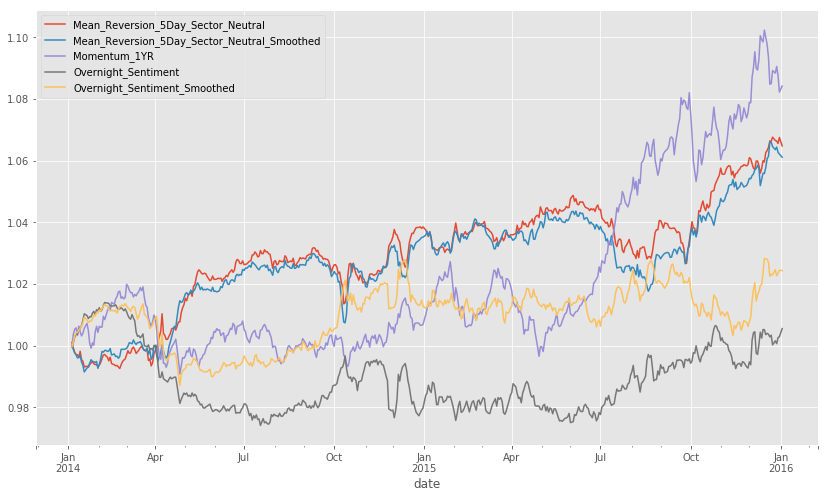

In [82]:
ls_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

(1+ls_factor_returns).cumprod().plot()

### Basis Points Per Day per Quantile
It is not enough to look just at the factor weighted return. A good alpha is also monotonic in quantiles. Let's looks the basis points for the factor returns.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8119aef5f8>,
      dtype=object)

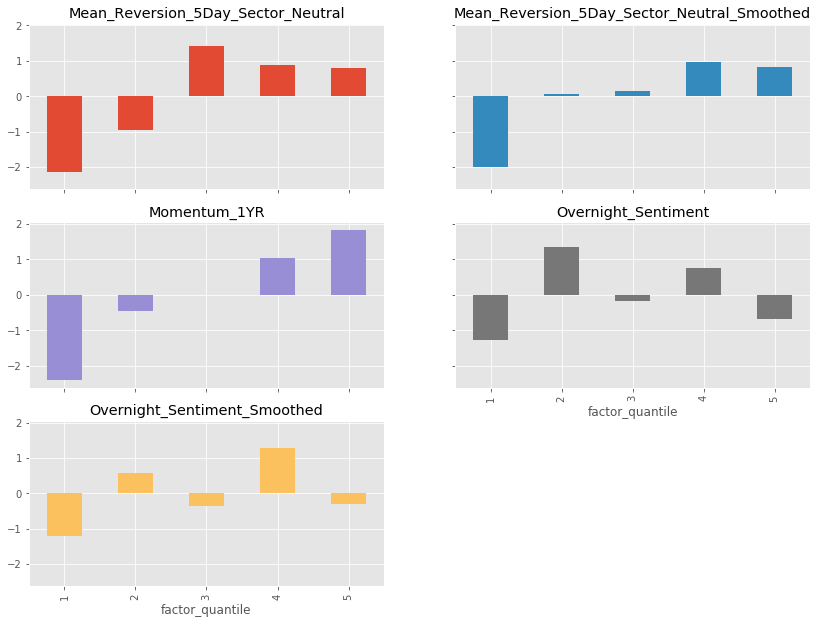

In [83]:
qr_factor_returns = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False)

What do you observe?

- None of these alphas are **strictly monotonic**; this should lead you to question why this is? Further research and refinement of the alphas needs to be done. What is it about these alphas that leads to the highest ranking stocks in all alphas except MR 5D smoothed to *not* perform the best.
- The majority of the return is coming from the **short side** in all these alphas. The negative return in quintile 1 is very large in all alphas. This could also a cause for concern becuase when you short stocks, you need to locate the short; shorts can be expensive or not available at all.
- If you look at the magnitude of the return spread (i.e., Q1 minus Q5), we are working with daily returns in the 0.03%, i.e., **3 basis points**, neighborhood *before all transaction costs, shorting costs, etc.*. Assuming 252 days in a year, that's 7.56% return annualized. Transaction costs may cut this in half. As such, it should be clear that these alphas can only survive in an institutional setting and that leverage will likely need to be applied in order to achieve an attractive return.

## Turnover Analysis

Without doing a full and formal backtest, we can analyze how stable the alphas are over time. Stability in this sense means that from period to period, the alpha ranks do not change much. Since trading is costly, we always prefer, all other things being equal, that the ranks do not change significantly per period. We can measure this with the **factor rank autocorrelation (FRA)**.

[alphalens.performance.factor_rank_autocorrelation](https://quantopian.github.io/alphalens/alphalens.html?highlight=factor_rank_autocorrelation#alphalens.performance.factor_rank_autocorrelation)

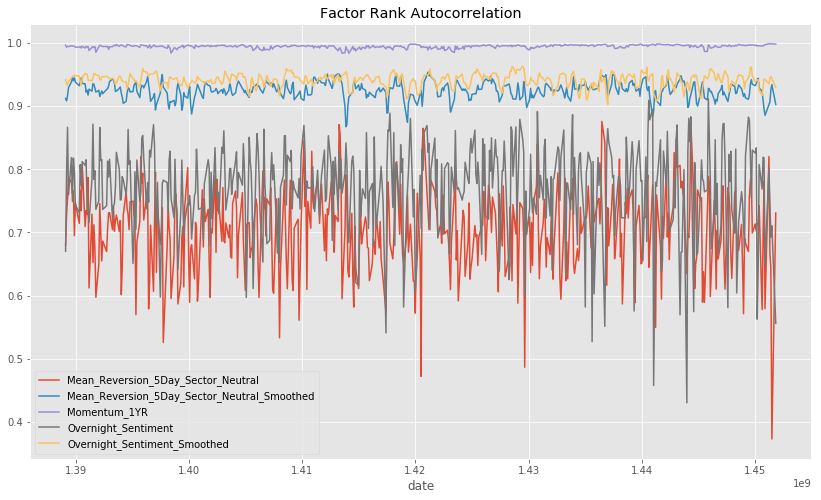

In [84]:
ls_FRA = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data)

ls_FRA.plot(title="Factor Rank Autocorrelation")

## Sharpe Ratio of the Alphas

The last analysis we'll do on the factors will be sharpe ratio. Implement `sharpe_ratio` to calculate the sharpe ratio of factor returns.

In [85]:
def sharpe_ratio(factor_returns, annualization_factor):
    """
    Get the sharpe ratio for each factor for the entire period

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns for each factor and date
    annualization_factor: float
        Annualization Factor

    Returns
    -------
    sharpe_ratio : Pandas Series of floats
        Sharpe ratio
    """
    # Sharpe ratio
    sharpe_ratio = annualization_factor * np.mean(factor_returns)/np.std(factor_returns, ddof=1)
    
    return sharpe_ratio

project_tests.test_sharpe_ratio(sharpe_ratio)

Tests Passed


### View Data
Let's see what the sharpe ratio for the factors are. Generally, a Sharpe Ratio of near 1.0 or higher is an acceptable single alpha for this universe.

In [86]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

Mean_Reversion_5Day_Sector_Neutral            1.37000000
Mean_Reversion_5Day_Sector_Neutral_Smoothed   1.27000000
Momentum_1YR                                  1.13000000
Overnight_Sentiment                           0.12000000
Overnight_Sentiment_Smoothed                  0.45000000
dtype: float64

## Question: What do you think would happen if we smooth the momentum factor? Would the performance increase, decrease, or no major change? Why?

The momentum factor seems to be smoothed enough. So, there will be no major change in the performance.

## The Combined Alpha Vector

To use these alphas in a portfolio, we need to combine them somehow so we get a single score per stock. This is a area where machine learning can be very helpful. In this module, however, we will take the simplest approach of combination: simply averaging the scores from each alpha.

In [87]:
selected_factors = all_factors.columns[[1, 2, 4]]
print('Selected Factors: {}'.format(', '.join(selected_factors)))

all_factors['alpha_vector'] = all_factors[selected_factors].mean(axis=1)
alphas = all_factors[['alpha_vector']]
alpha_vector = alphas.loc[all_factors.index.get_level_values(0)[-1]]
alpha_vector.head()

Selected Factors: Mean_Reversion_5Day_Sector_Neutral_Smoothed, Momentum_1YR, Overnight_Sentiment_Smoothed


,alpha_vector
asset,
Equity(0 [A]),-0.58642457
Equity(1 [AAL]),-0.45333845
Equity(2 [AAP]),-0.69993898
Equity(3 [AAPL]),-0.06790952
Equity(4 [ABBV]),-1.21617871


# Optimal Portfolio Constrained by Risk Model
You have an alpha model and a risk model. Let's find a portfolio that trades as close as possible to the alpha model but limiting risk as measured by the risk model. You'll be building thie optimizer for this portfolio. To help you out. we have provided you with an abstract class called `AbstractOptimalHoldings`.

In [88]:
from abc import ABC, abstractmethod


class AbstractOptimalHoldings(ABC):    
    @abstractmethod
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        
        raise NotImplementedError()
    
    @abstractmethod
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        
        raise NotImplementedError()
        
    def _get_risk(self, weights, factor_betas, alpha_vector_index, factor_cov_matrix, idiosyncratic_var_vector):
        f = factor_betas.loc[alpha_vector_index].values.T * weights
        X = factor_cov_matrix
        S = np.diag(idiosyncratic_var_vector.loc[alpha_vector_index].values.flatten())

        return cvx.quad_form(f, X) + cvx.quad_form(weights, S)
    
    def find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector):
        weights = cvx.Variable(len(alpha_vector))
        risk = self._get_risk(weights, factor_betas, alpha_vector.index, factor_cov_matrix, idiosyncratic_var_vector)
        
        obj = self._get_obj(weights, alpha_vector)
        constraints = self._get_constraints(weights, factor_betas.loc[alpha_vector.index].values, risk)
        
        prob = cvx.Problem(obj, constraints)
        prob.solve(max_iters=500)

        optimal_weights = np.asarray(weights.value).flatten()
        
        return pd.DataFrame(data=optimal_weights, index=alpha_vector.index)

## Objective and Constraints
Using this class as a base class, you'll implement the `OptimalHoldings` class. There's two functions that need to be implemented in this class, the `_get_obj` and `_get_constraints` functions.

The `_get_obj` function should return an CVXPY objective function that maximizes $ \alpha^T * x \\ $, where $ x $ is the portfolio weights and $ \alpha $ is the alpha vector.

The `_get_constraints` function should return a list of the following constraints:
- $ r \leq risk_{\text{cap}}^2 \\ $
- $ B^T * x \preceq factor_{\text{max}} \\ $
- $ B^T * x \succeq factor_{\text{min}} \\ $
- $ x^T\mathbb{1} = 0 \\ $
- $ \|x\|_1 \leq 1 \\ $
- $ x \succeq weights_{\text{min}} \\ $
- $ x \preceq weights_{\text{max}} $

Where $ x $ is the portfolio weights, $ B $ is the factor betas, and $ r $ is the portfolio risk

The first constraint is that the predicted risk be less than some maximum limit. The second and third constraints are on the maximum and minimum portfolio factor exposures. The fourth constraint is the "market neutral constraint: the sum of the weights must be zero. The fifth constraint is the leverage constraint: the sum of the absolute value of the weights must be less than or equal to 1.0. The last are some minimum and maximum limits on individual holdings.

In [89]:
class OptimalHoldings(AbstractOptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        # Testing
        assert(len(alpha_vector.columns) == 1)

        # Objective function
        objective = cvx.Maximize(np.array(alpha_vector.T) * weights)
        
        return objective
    
    
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        # Testing
        assert(len(factor_betas.shape) == 2)
        
        # Constraints
        constraints = [risk <= self.risk_cap**2,\
                       np.array(factor_betas.T) * weights <= self.factor_max,\
                       np.array(factor_betas.T) * weights >= self.factor_min,\
                       sum(weights) == 0,\
                       sum(cvx.abs(weights)) <=1,\
                       weights <= self.weights_max,\
                       weights >= self.weights_min]
        
        return constraints

    
    def __init__(self, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min


project_tests.test_optimal_holdings_get_obj(OptimalHoldings)
project_tests.test_optimal_holdings_get_constraints(OptimalHoldings)

Running Integration Test on Problem.solve:
> constaints = [sum(weights) == 0.0, sum(cvx.abs(weights)) <= 1.0]
> obj = optimal_holdings._get_obj(weights, alpha_vector)
> prob = cvx.Problem(obj, constaints)
> prob.solve(max_iters=500)
> solution = np.asarray(weights.value).flatten()

Tests Passed

Running Integration Test on Problem.solve:
> x = np.diag(np.arange(3))
> s = np.diag(np.arange(4))
> factor_betas = np.arange(4 * 3).reshape([4, 3])
> risk = cvx.quad_form(weights * factor_betas, x) + cvx.quad_form(weights, s)
> constaints = optimal_holdings._get_constraints(weights, factor_betas, risk)
> obj = cvx.Maximize([0, 1, 5, -1] * weights)
> prob = cvx.Problem(obj, constaints)
> prob.solve(max_iters=500)
> solution = np.asarray(weights.value).flatten()



AssertionError: Wrong value for solve_problem.

INPUT weights:
var51674

OUTPUT solution:
[-0.01095335  0.00275894  0.02684953 -0.01865512]

EXPECTED OUTPUT FOR solution:
[-0.01095207  0.0027576   0.02684978 -0.01865519]


### View Data
With the `OptimalHoldings` class implemented, let's see the weights it generates.

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


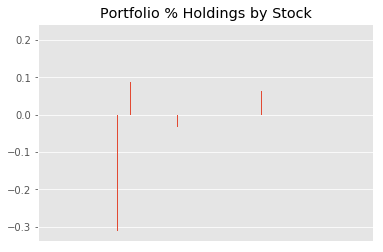

In [41]:
optimal_weights = OptimalHoldings().find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

Yikes. It put most of the weight in a few stocks.

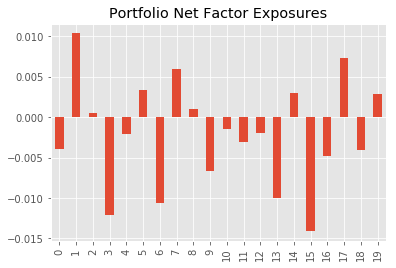

In [42]:
project_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

## Optimize with a Regularization Parameter
In order to enforce diversification, we'll use regularization in the objective function. We'll create a new class called `OptimalHoldingsRegualization` which gets its constraints from the `OptimalHoldings` class. In this new class, implement the `_get_obj` function to return a CVXPY objective function that maximize $ \alpha^T * x + \lambda\|x\|_2\\ $, where $ x $ is the portfolio weights, $ \alpha $ is the alpha vector, and $ \lambda $ is the regularization parameter.

**Note:** * $ \lambda $ is located in `self.lambda_reg`. *

In [43]:
class OptimalHoldingsRegualization(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        # Testing
        assert(len(alpha_vector.columns) == 1)
        
        # Objective function
        objective = cvx.Maximize(alpha_vector.values.T * weights - self.lambda_reg * cvx.norm(weights, 2))
        
        return objective

    
    def __init__(self, lambda_reg=0.5, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.lambda_reg = lambda_reg
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min
        

project_tests.test_optimal_holdings_regualization_get_obj(OptimalHoldingsRegualization)

Running Integration Test on Problem.solve:
> constaints = [sum(weights) == 0.0, sum(cvx.abs(weights)) <= 1.0]
> obj = optimal_holdings_regualization._get_obj(weights, alpha_vector)
> prob = cvx.Problem(obj, constaints)
> prob.solve(max_iters=500)
> solution = np.asarray(weights.value).flatten()

Tests Passed


### View Data

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


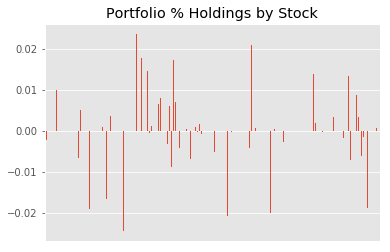

In [44]:
optimal_weights_1 = OptimalHoldingsRegualization(lambda_reg=5.0).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_1.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

Nice. Well diversified.

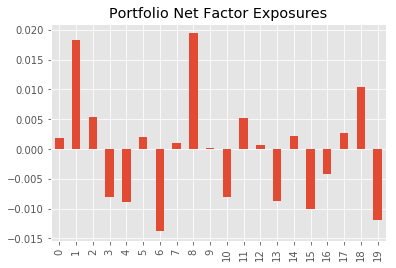

In [45]:
project_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights_1).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

## Optimize with a Strict Factor Constraints and Target Weighting
Another common formulation is to take a predefined target weighting, $x^*$ (e.g., a quantile portfolio), and solve to get as close to that portfolio while respecting portfolio-level constraints. For this next class, `OptimalHoldingsStrictFactor`, you'll implement the `_get_obj` function to minimize on on $ \|x - x^*\|_2 $, where $ x $ is the portfolio weights  $ x^* $ is the target weighting.

In [46]:
class OptimalHoldingsStrictFactor(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        # Testing
        assert(len(alpha_vector.columns) == 1)
        
        # Alpha vector values
        alpha_vector_values = alpha_vector.values.flatten()
        
        # X star
        x_star = (alpha_vector_values - np.mean(alpha_vector_values)) / (np.sum(np.abs(alpha_vector_values)))
        
        # Objective function
        objective = cvx.Minimize(cvx.norm(weights - x_star,2))
        
        return objective

project_tests.test_optimal_holdings_strict_factor_get_obj(OptimalHoldingsStrictFactor)

Running Integration Test on Problem.solve:
> constaints = [sum(weights) == 0.0, sum(cvx.abs(weights)) <= 1.0]
> obj = optimal_holdings_strict_factor._get_obj(weights, alpha_vector)
> prob = cvx.Problem(obj, constaints)
> prob.solve(max_iters=500)
> solution = np.asarray(weights.value).flatten()

Tests Passed


### View Data

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


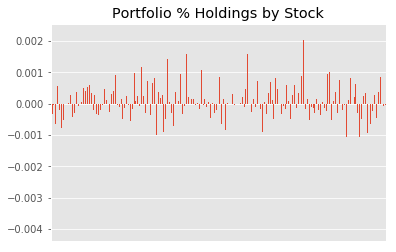

In [47]:
optimal_weights_2 = OptimalHoldingsStrictFactor(
    weights_max=0.02,
    weights_min=-0.02,
    risk_cap=0.0015,
    factor_max=0.015,
    factor_min=-0.015).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_2.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

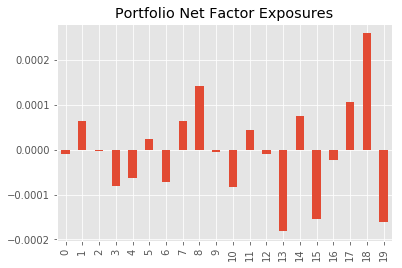

In [48]:
project_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights_2).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)